<a href="https://colab.research.google.com/github/Nov05/Google-Colaboratory/blob/master/20230817_scikit_lego_meta_model_example_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **\<begin>**  

https://scikit-lego.netlify.app/meta.html  

> Certain models in scikit-lego are **“meta”**. Meta models are models that depend on other estimators that go in and these models will add features to the input model. One way of thinking of a meta model is to consider it to be a way to **“decorate”** a model.  

In [ ]:
%%capture
!pip install sklego
## Successfully installed Deprecated-1.2.14 pynndescent-0.5.10 scikit-lego-0.6.15 sklego-0.0 umap-learn-0.5.3

# **Thresholder**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

from sklego.meta import Thresholder

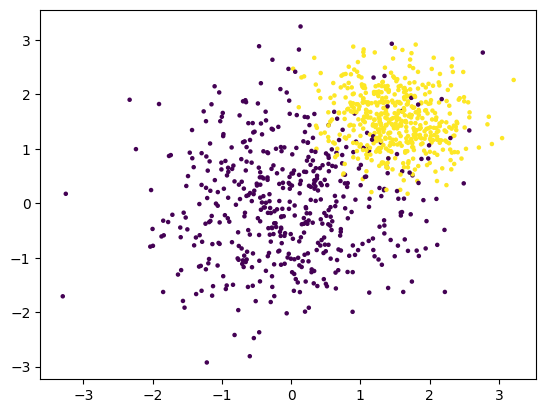

In [ ]:
X, y = make_blobs(1000, centers=[(0, 0), (1.5, 1.5)], cluster_std=[1, 0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

In [ ]:
%%time
pipe = Pipeline([
    ("model", Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1))
])
mod = GridSearchCV(estimator=pipe,
                   param_grid = {"model__threshold": np.linspace(0.1, 0.9, 500)},
                   scoring={"precision": make_scorer(precision_score),
                            "recall": make_scorer(recall_score),
                            "accuracy": make_scorer(accuracy_score)},
                   refit="precision",
                   cv=5)
_ = mod.fit(X, y)

CPU times: user 16.6 s, sys: 112 ms, total: 16.7 s
Wall time: 21.7 s


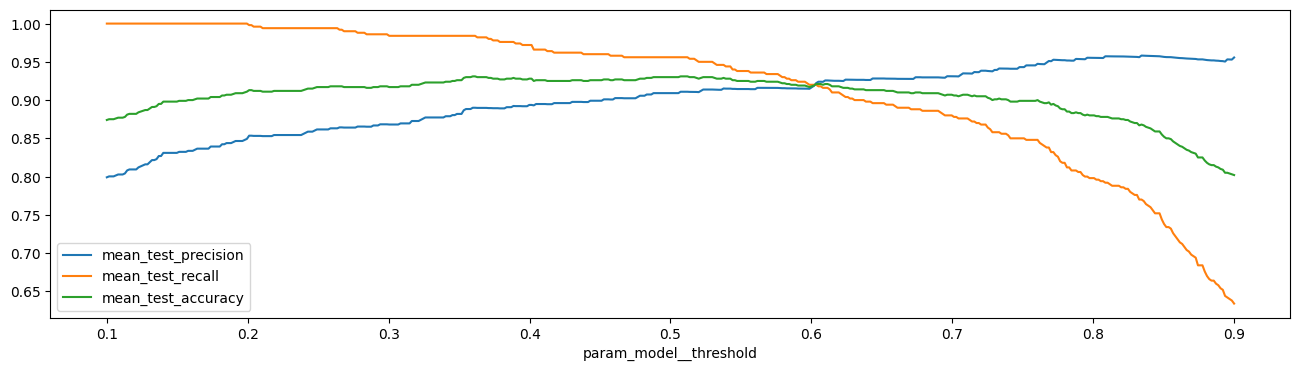

In [ ]:
(pd.DataFrame(mod.cv_results_)
 .set_index("param_model__threshold")
 [['mean_test_precision', 'mean_test_recall', 'mean_test_accuracy']]
 .plot(figsize=(16, 4)));

# **Saving compute**  

`refit=False`

In [ ]:
%%time
# Train an original model
orig_model = LogisticRegression(solver='lbfgs')
orig_model.fit(X, y)

# Ensure that refit=False
pipe = Pipeline([
    ("model", Thresholder(orig_model, threshold=0.1, refit=False))
])

# This should now be a fair bit quicker.
mod = GridSearchCV(estimator=pipe,
                   param_grid = {"model__threshold": np.linspace(0.1, 0.9, 50)},
                   scoring={"precision": make_scorer(precision_score),
                            "recall": make_scorer(recall_score),
                            "accuracy": make_scorer(accuracy_score)},
                   refit="precision",
                   cv=5)

_ = mod.fit(X, y);

CPU times: user 1.48 s, sys: 12 ms, total: 1.49 s
Wall time: 1.53 s


# **Grouped Prediction**  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklego.datasets import load_chicken
from sklego.preprocessing import ColumnSelector

df = load_chicken(as_frame=True)

def plot_model(model):
    df = load_chicken(as_frame=True)
    model.fit(df[['diet', 'time']], df['weight'])
    metric_df = df[['diet', 'time', 'weight']].assign(pred=lambda d: model.predict(d[['diet', 'time']]))
    metric = mean_absolute_error(metric_df['weight'], metric_df['pred'])
    plt.figure(figsize=(12, 4))
    plt.scatter(df['time'], df['weight'])
    for i in [1, 2, 3, 4]:
        pltr = metric_df[['time', 'diet', 'pred']].drop_duplicates().loc[lambda d: d['diet'] == i]
        plt.plot(pltr['time'], pltr['pred'], color='.rbgy'[i])
    plt.title(f"linear model per group, MAE: {np.round(metric, 2)}");

In [ ]:
print(df.shape)
df.sample(6)

(578, 4)


,weight,time,chick,diet
204,106,16,19,1
576,264,20,50,4
90,110,12,8,1
389,53,2,35,3
432,192,16,38,3
321,106,10,29,2


## **Model 1: Linear Regression with Dummies**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


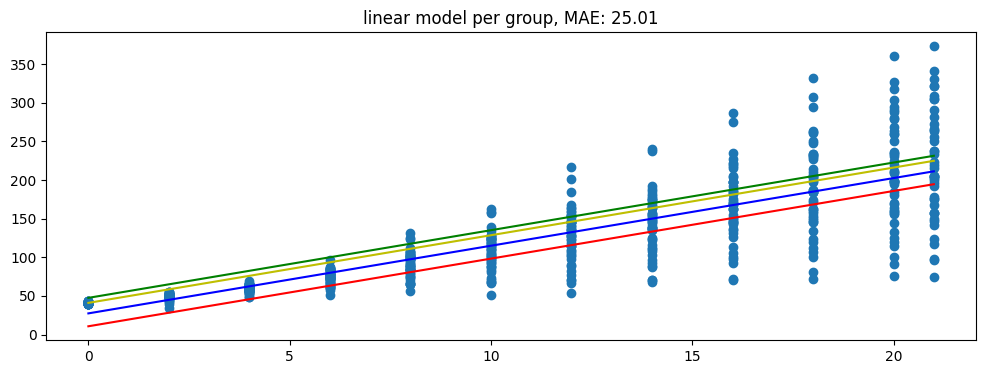

In [ ]:
feature_pipeline = Pipeline([
    ("datagrab", FeatureUnion([
         ("discrete", Pipeline([
             ("grab", ColumnSelector("diet")),
             ("encode", OneHotEncoder(categories="auto", sparse=False))
         ])),
         ("continuous", Pipeline([
             ("grab", ColumnSelector("time")),
             ("standardize", StandardScaler())
         ]))
    ]))
])

pipe = Pipeline([
    ("transform", feature_pipeline),
    ("model", LinearRegression())
])

plot_model(pipe)

## **Model 2: Linear Regression in GroupedEstimation**  

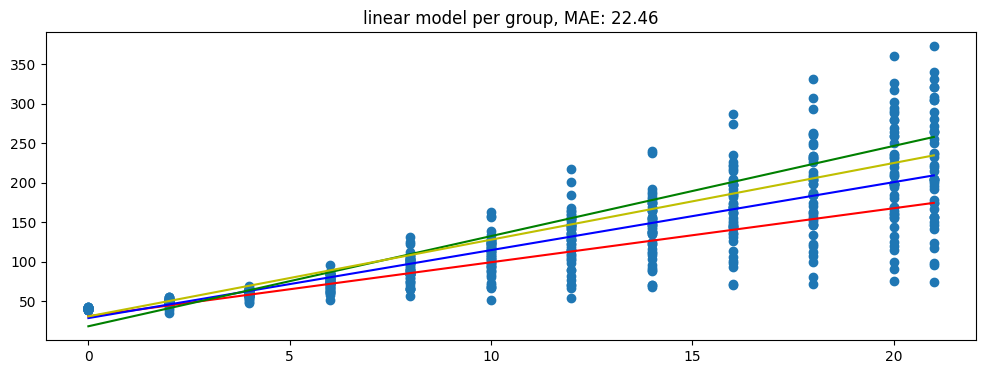

In [ ]:
from sklego.meta import GroupedPredictor
mod = GroupedPredictor(LinearRegression(), groups=["diet"])
plot_model(mod)

## **Model 3: Dummy Regression in GroupedEstimation**

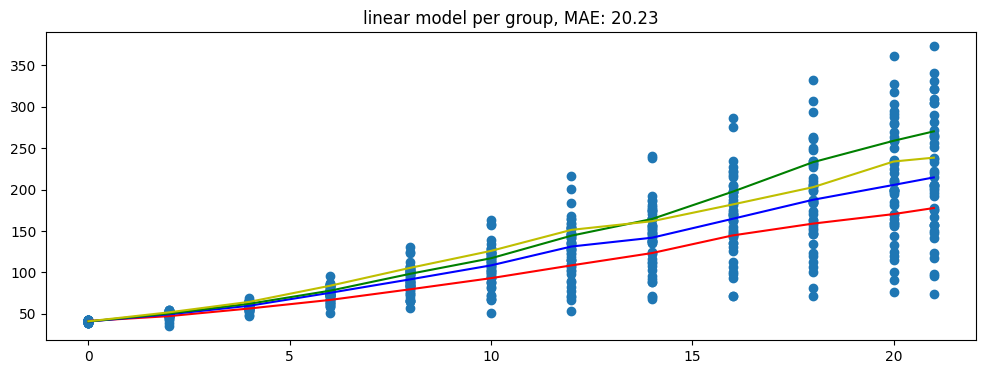

In [ ]:
from sklearn.dummy import DummyRegressor
feature_pipeline = Pipeline([
    ("datagrab", FeatureUnion([
         ("discrete", Pipeline([
             ("grab", ColumnSelector("diet")),
         ])),
         ("continuous", Pipeline([
             ("grab", ColumnSelector("time")),
         ]))
    ]))
])
pipe = Pipeline([
    ("transform", feature_pipeline),
    ("model", GroupedPredictor(DummyRegressor(strategy="mean"), groups=[0, 1]))
])
plot_model(pipe)

# **Grouped Transformation**

In [ ]:
from sklego.datasets import load_penguins
df_peng = (load_penguins(as_frame=True)
           .dropna()
           .drop(columns=['island', 'bill_depth_mm', 'bill_length_mm']))
df_peng.sample(6)

,species,flipper_length_mm,body_mass_g,sex
270,Gentoo,214.0,4925.0,female
336,Chinstrap,206.0,3950.0,male
33,Adelie,184.0,3900.0,male
195,Gentoo,216.0,4750.0,male
225,Gentoo,217.0,5200.0,female
315,Chinstrap,205.0,4500.0,male


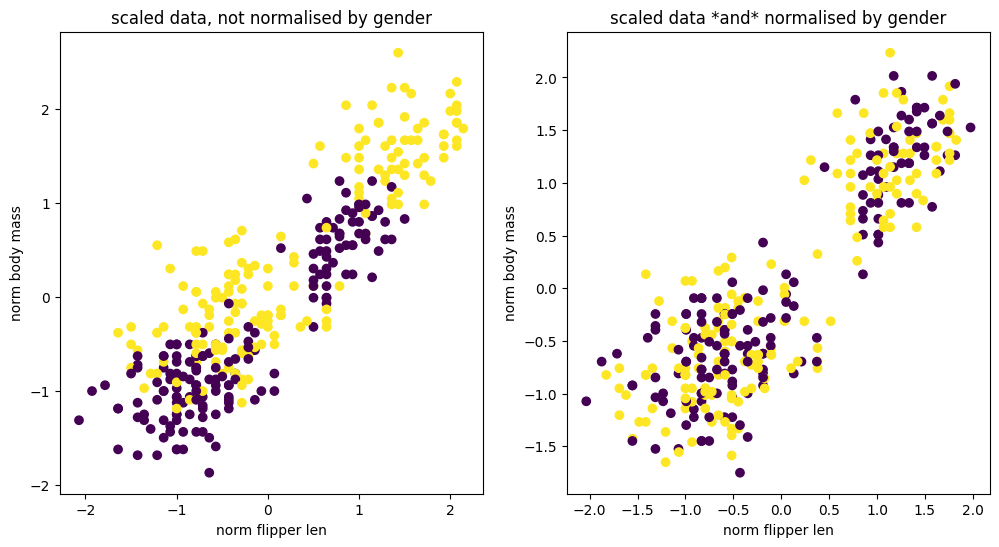

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklego.meta import GroupedTransformer

plt.figure(figsize=(12, 6))
# we'll drop species because we're not grouping on it
df_peng = df_peng.drop(columns=["species"])

plt.subplot(121)
X = df_peng.drop(columns=['sex']).values
X_tfm = StandardScaler().fit_transform(X)
plt.scatter(X_tfm[:, 0], X_tfm[:, 1], c=df_peng['sex']=='male')
plt.xlabel("norm flipper len")
plt.ylabel("norm body mass")
plt.title("scaled data, not normalised by gender")

plt.subplot(122)
X_tfm = GroupedTransformer(StandardScaler(), groups=['sex']).fit_transform(df_peng)
plt.scatter(X_tfm[:, 0], X_tfm[:, 1], c=df_peng['sex']=='male')
plt.xlabel("norm flipper len")
plt.ylabel("norm body mass")
plt.title("scaled data *and* normalised by gender");

# **Decayed Estimation**

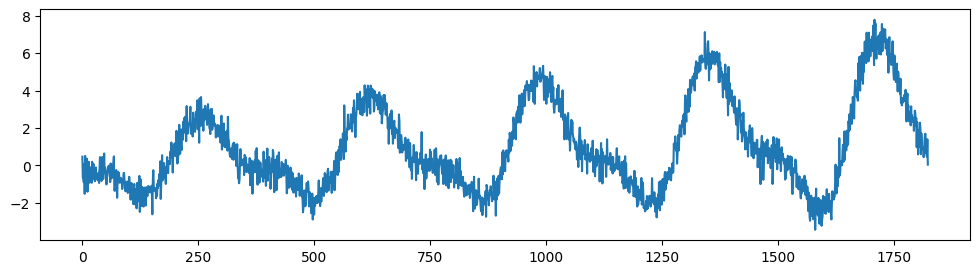

In [ ]:
from sklearn.dummy import DummyRegressor
# from sklego.meta import GroupedEstimator, DecayEstimator
from sklego.meta import GroupedPredictor, DecayEstimator
from sklego.datasets import make_simpleseries
yt = make_simpleseries(seed=1)
df = (pd.DataFrame({"yt": yt,
                   "date": pd.date_range("2000-01-01", periods=len(yt))})
      .assign(m=lambda d: d.date.dt.month)
      .reset_index())
plt.figure(figsize=(12, 3))
plt.plot(make_simpleseries(seed=1));

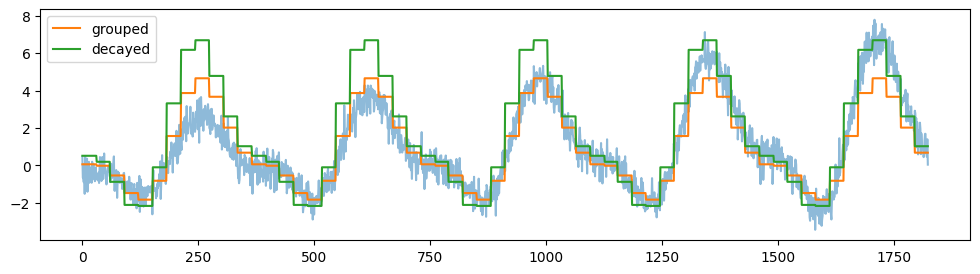

In [ ]:
## DeprecationWarning: Call to deprecated function (or staticmethod) GroupedEstimator. (Please use `sklego.meta.GroupedPredictor` instead.
## This object will be removed from the meta submodule in version 0.7.0.) -- Deprecated since version 0.5.2.
# mod1 = (GroupedEstimator(DummyRegressor(), groups=["m"])
#         .fit(df[['m']], df['yt']))
# mod2 = (GroupedEstimator(DecayEstimator(DummyRegressor(), decay=0.9), groups=["m"])
#         .fit(df[['index', 'm']], df['yt']))
mod1 = (GroupedPredictor(DummyRegressor(), groups=["m"])
        .fit(df[['m']], df['yt']))
mod2 = (GroupedPredictor(DecayEstimator(DummyRegressor(), decay=0.9), groups=["m"])
        .fit(df[['index', 'm']], df['yt']))
plt.figure(figsize=(12, 3))
plt.plot(df['yt'], alpha=0.5);
plt.plot(mod1.predict(df[['m']]), label="grouped")
plt.plot(mod2.predict(df[['index', 'm']]), label="decayed")
plt.legend();

# **Confusion Balancer**

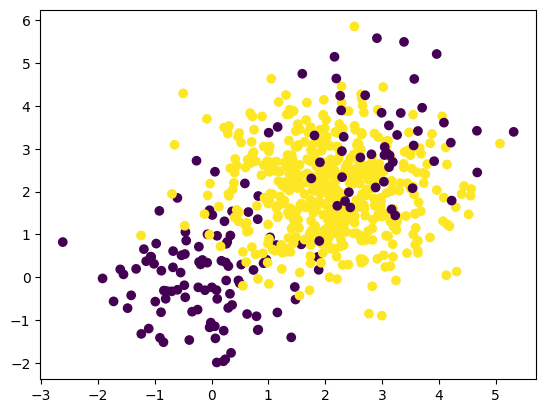

In [ ]:
## Disclaimer: This is an experimental feature.
n1, n2, n3 = 100, 500, 50
np.random.seed(42)
X = np.concatenate([np.random.normal(0, 1, (n1, 2)),
                    np.random.normal(2, 1, (n2, 2)),
                    np.random.normal(3, 1, (n3, 2))],
                   axis=0)
y = np.concatenate([np.zeros((n1, 1)),
                    np.ones((n2, 1)),
                    np.zeros((n3, 1))],
                   axis=0).reshape(-1)
plt.scatter(X[:, 0], X[:, 1], c=y);

In [ ]:
from sklearn.metrics import confusion_matrix
mod = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)
cfm = confusion_matrix(y, mod.fit(X, y).predict(X))
cfm

array([[ 72,  78],
       [  4, 496]])

In [ ]:
cfm.T / cfm.T.sum(axis=1).reshape(-1, 1)

array([[0.94736842, 0.05263158],
       [0.1358885 , 0.8641115 ]])

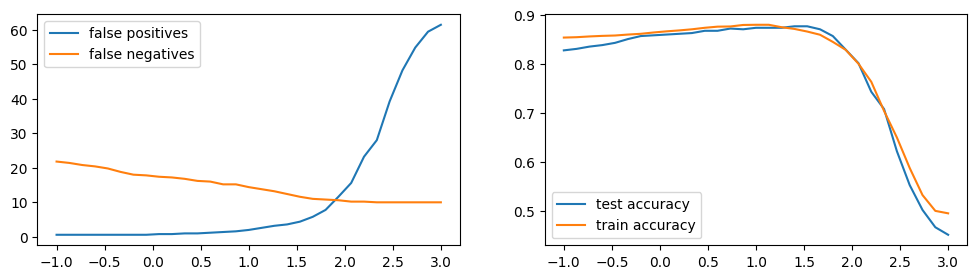

In [ ]:
def false_positives(mod, x, y):
    return (mod.predict(x) != y)[y == 1].sum()

def false_negatives(mod, x, y):
    return (mod.predict(x) != y)[y == 0].sum()

from sklego.meta import ConfusionBalancer
cf_mod = ConfusionBalancer(LogisticRegression(solver='lbfgs', max_iter=1000), alpha=1.0)

## TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'iid'
## https://github.com/scikit-learn/scikit-learn/pull/9103 (deprecated, on Jun 10, 2017)
grid = GridSearchCV(cf_mod,
                    param_grid={'alpha': np.linspace(-1.0, 3.0, 31)},
                    scoring={
                        "accuracy": make_scorer(accuracy_score),
                        "positives": false_positives,
                        "negatives": false_negatives
                    },
                    n_jobs=-1,
                    # iid=True, ## deprecated
                    return_train_score=True,
                    refit="negatives",
                    cv=5)
df = pd.DataFrame(grid.fit(X, y).cv_results_)
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(df['param_alpha'], df['mean_test_positives'], label="false positives")
plt.plot(df['param_alpha'], df['mean_test_negatives'], label="false negatives")
plt.legend()
plt.subplot(122)
plt.plot(df['param_alpha'], df['mean_test_accuracy'], label="test accuracy")
plt.plot(df['param_alpha'], df['mean_train_accuracy'], label="train accuracy")
plt.legend();


# **Zero-Inflated Regressor**  

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklego.meta import ZeroInflatedRegressor
np.random.seed(0)
X = np.random.randn(10000, 4)
y = ((X[:, 0]>0) & (X[:, 1]>0)) * np.abs(X[:, 2] * X[:, 3]**2) # many zeroes here, in about 75% of the cases.
zir = ZeroInflatedRegressor(
    classifier=RandomForestClassifier(random_state=0),
    regressor=RandomForestRegressor(random_state=0)
)
print('ZIR (RFC+RFR) r²:', cross_val_score(zir, X, y).mean())
print('RFR r²:', cross_val_score(RandomForestRegressor(random_state=0), X, y).mean())
## RFC = RandomForestClassifier
## RFR = RandomForestRegressor

ZIR (RFC+RFR) r²: 0.8992404366385873
RFR r²: 0.8516522752031502


# **OutlierClassifier**

In [ ]:
from sklego.meta.outlier_classifier import OutlierClassifier
from sklearn.ensemble import IsolationForest
n_normal = 10000
n_outlier = 100
np.random.seed(0)
X = np.hstack((np.random.normal(size=n_normal), np.random.normal(10, size=n_outlier))).reshape(-1,1)
y = np.hstack((np.asarray([0]*n_normal), np.asarray([1]*n_outlier)))
clf = OutlierClassifier(IsolationForest(n_estimators=1000, contamination=n_outlier/n_normal, random_state=0))
clf.fit(X, y)

OutlierClassifier(model=IsolationForest(contamination=0.01, n_estimators=1000,
                                        random_state=0))

In [ ]:
print('inlier: ', clf.predict([[0]]))
print('outlier: ', clf.predict([[10]]))

inlier:  [0.]
outlier:  [1.]


In [ ]:
clf.predict_proba([[10]]) ## (inlier, outlier)

array([[0.0376881, 0.9623119]])

In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
estimators = [
    ('anomaly', OutlierClassifier(IsolationForest())),
    ('classifier', RandomForestClassifier())
    ]
stacker = StackingClassifier(estimators, stack_method='predict_proba', passthrough=True)
stacker.fit(X,y)

StackingClassifier(estimators=[('anomaly',
                                OutlierClassifier(model=IsolationForest())),
                               ('classifier', RandomForestClassifier())],
                   passthrough=True, stack_method='predict_proba')

# **\<end>**  